In [1]:
print("Hello from hullstockprediction!")

Hello from hullstockprediction!


In [9]:
import pandas as pd

df = pd.read_csv("data/train.csv")

print(df.head(5))

   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]


# データセットの説明

このコンペティションでは、特別に設計された市場データの特徴量群を用いて、S&P 500 指数の日次リターンを予測することが求められます。

## コンペのフェーズとデータ更新

このコンペは以下の2つのフェーズで進行します。

1. モデル学習フェーズ（Model Training Phase）
　6か月分の過去データをテストセットとして使用します。
　これらの価格データはすでに公開されているため、このフェーズのリーダーボードスコアは意味を持ちません。

1. 予測フェーズ（Forecasting Phase）
　提出締切後に収集されるテストセットを用いて評価が行われます。
　スコアが付与されるテストデータの規模は、学習フェーズのスコア付きデータとほぼ同じになる見込みです。

予測フェーズ中、評価API（evaluation API） は「公開テストセットの開始から非公開テストセットの終了まで」のデータを順に配信します。
これには提出締切より前の取引日も含まれますが、それらはスコア計算の対象外です。
また、APIが最初に返す date_id はコンペ期間中ずっと固定です。

## 学習データ
### train.csv — 歴史的な市場データ。
数十年にわたる期間をカバーしており、初期の方のデータには欠損値が多く含まれます。

| カラム名        | 説明                                    |
| ----------- | ------------------------------------- |
| **date_id** | 1取引日を表す識別子。つまり、各行は「ある1日の市場データ」を意味します。 |
| **M***      | 市場ダイナミクス／テクニカル特徴（例：M1〜M18）。           |
| **E***      | マクロ経済特徴（例：E1〜E20）。                    |
| **I***      | 金利に関する特徴（例：I1〜I9）。                    |
| **P***      | 価格・バリュエーション関連の特徴（例：P1〜P13）。           |
| **V***      | ボラティリティ（変動性）関連の特徴（例：V1〜V13）。          |
| **S***      | センチメント（市場心理）関連の特徴（例：S1〜S12）。          |
| **MOM***    | モメンタム特徴（現在はデータなし）。                    |
| **D***      | ダミー（バイナリ）特徴（例：D1〜D9）。                 |


> ※ D 系、date_id、returns 以外は欠損値（null）を含みます。

| カラム名                              | 説明                                 |
| --------------------------------- | --------------------------------------------------------------------- |
| **forward_returns**               | S&P500を買い、翌日に売った場合のリターン。**訓練データにのみ**含まれる。                |
| **risk_free_rate**                | フェデラル・ファンド・レート（無リスク金利）。**訓練データにのみ**含まれる。              |
| **market_forward_excess_returns** | 「期待値に対する」将来リターン。<br>計算方法：`forward_returns` から過去5年間の平均将来リターンを引き、さらに**中央値絶対偏差 (MAD)** を使って閾値4でウィンザー化（外れ値抑制）した値。**訓練データにのみ**含まれる。 |



### test.csv
未知のテストセット構造を模した模擬データ。
公開リーダーボード用のテストセットは、train.csv の最後の180日 (date_id) をコピーしたもの。
そのため、公開スコアは参考値にすぎません。
評価APIが提供する本番用ファイルは、学習フェーズ中に更新される可能性があります。

| カラム名                                   | 説明                                                                     |
| -------------------------------------- | ---------------------------------------------------------------------- |
| `date_id`                              | 取引日ID                                                                  |
| `[feature_name]`                       | 特徴量列（`train.csv` と同一）                                                  |
| `is_scored`                            | 評価対象行かどうか。学習フェーズでは最初の180行のみ `True`。                                    |
| `lagged_forward_returns`               | S&P500 を1日前に買い翌日に売った場合のリターン（1日遅れで提供）                                   |
| `lagged_risk_free_rate`                | 1日遅れで提供されるフェデラル・ファンド金利                                                 |
| `lagged_market_forward_excess_returns` | 1日遅れで提供される「期待値に対する forward_returns」。<br>**過去5年平均を差し引き、MAD=4で外れ値処理済み**。 |

## まとめ

ターゲットは market_forward_excess_returns（＝市場平均に対する翌日リターンの上振れ・下振れ）。

特徴量は匿名化されており、価格・金利・ボラティリティ・センチメントなど多様な市場要因を表す。

評価APIは、公開期間＋非公開期間のデータを時系列順に供給して予測精度を評価する。


In [22]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   int64  
 1   D1                             8990 non-null   int64  
 2   D2                             8990 non-null   int64  
 3   D3                             8990 non-null   int64  
 4   D4                             8990 non-null   int64  
 5   D5                             8990 non-null   int64  
 6   D6                             8990 non-null   int64  
 7   D7                             8990 non-null   int64  
 8   D8                             8990 non-null   int64  
 9   D9                             8990 non-null   int64  
 10  E1                             7206 non-null   float64
 11  E10                            7984 non-null   float64
 12  E11                            7984 non-null   f

(8990, 98)


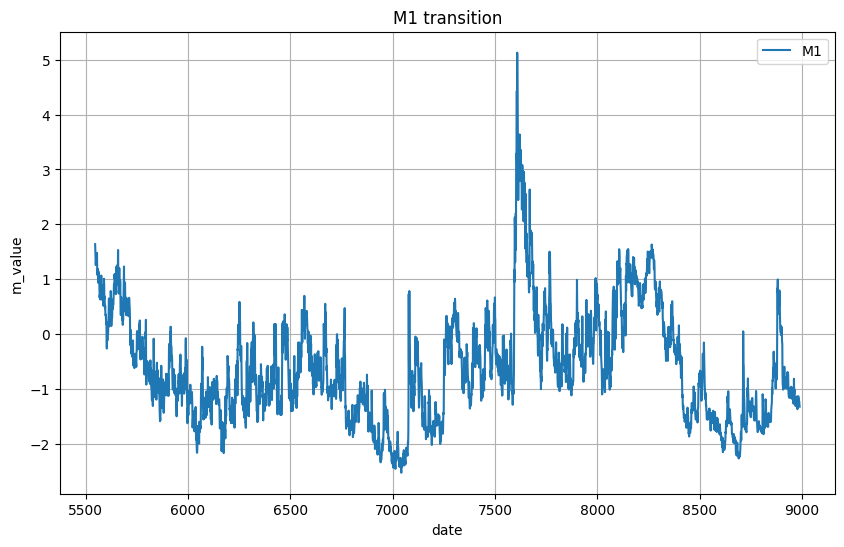

In [23]:
import matplotlib.pyplot as plt

print(df.shape)

# グラフのサイズを設定
plt.figure(figsize=(10, 6))

# 折れ線グラフを描画
# df.plot()でも描画可能ですが、より詳細な設定をする場合は以下のように書きます
plt.plot(df['date_id'], df['M1'], label='M1')

# グラフのタイトルを設定
plt.title('M1 transition')

# x軸のラベルを設定
plt.xlabel('date')

# y軸のラベルを設定
plt.ylabel('m_value')

# 凡例を表示
plt.legend()

# グリッド線を表示
plt.grid(True)

# グラフを表示
plt.show()

<Figure size 3000x800 with 0 Axes>

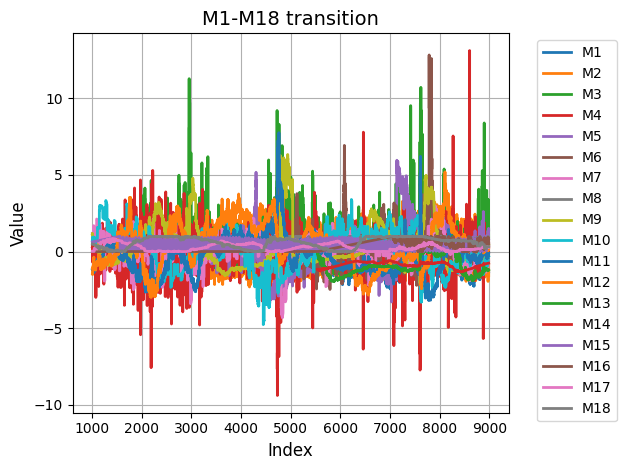

In [24]:
plt.figure(figsize=(30, 8))  # グラフサイズを大きめに設定

# M1からM18までの列を選択して描画
columns = [f'M{i}' for i in range(1, 19)]
df[columns].plot(linewidth=2)

plt.title('M1-M18 transition', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 凡例を右側に配置
plt.tight_layout()  # レイアウトの自動調整
plt.show()

<Figure size 3000x800 with 0 Axes>

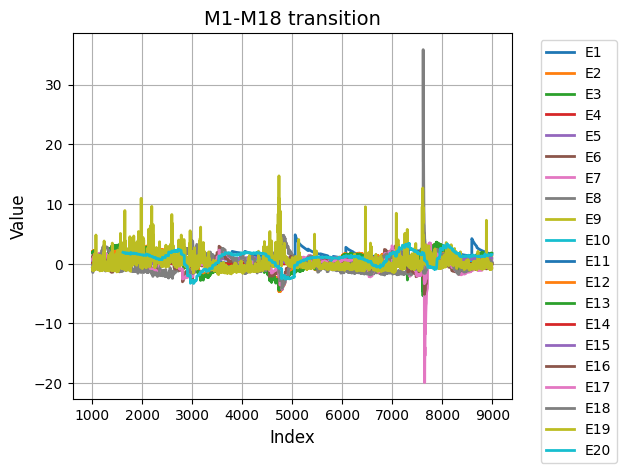

In [25]:
plt.figure(figsize=(30, 8))  # グラフサイズを大きめに設定

# M1からM18までの列を選択して描画
columns = [f'E{i}' for i in range(1, 21)]
df[columns].plot(linewidth=2)

plt.title('M1-M18 transition', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 凡例を右側に配置
plt.tight_layout()  # レイアウトの自動調整
plt.show()

<Figure size 3000x800 with 0 Axes>

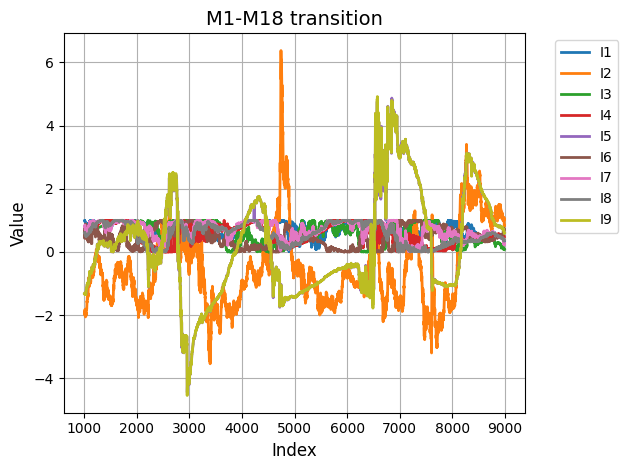

In [27]:
plt.figure(figsize=(30, 8))  # グラフサイズを大きめに設定

# M1からM18までの列を選択して描画
columns = [f'I{i}' for i in range(1, 10)]
df[columns].plot(linewidth=2)

plt.title('M1-M18 transition', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 凡例を右側に配置
plt.tight_layout()  # レイアウトの自動調整
plt.show()

<Figure size 3000x800 with 0 Axes>

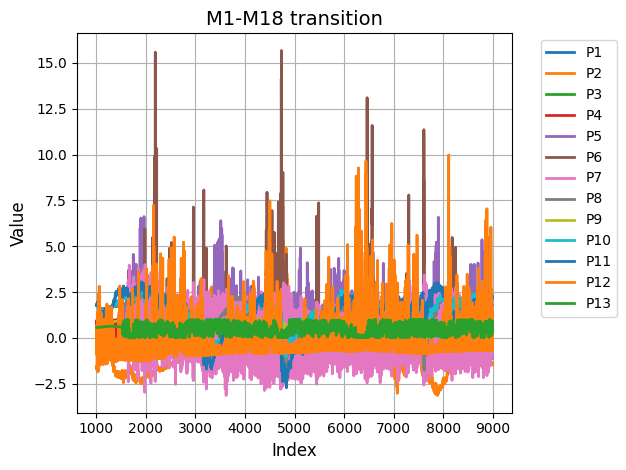

In [31]:
plt.figure(figsize=(30, 8))  # グラフサイズを大きめに設定

# M1からM18までの列を選択して描画
columns = [f'P{i}' for i in range(1, 14)]
df[columns].plot(linewidth=2)

plt.title('M1-M18 transition', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 凡例を右側に配置
plt.tight_layout()  # レイアウトの自動調整
plt.show()

<Figure size 3000x800 with 0 Axes>

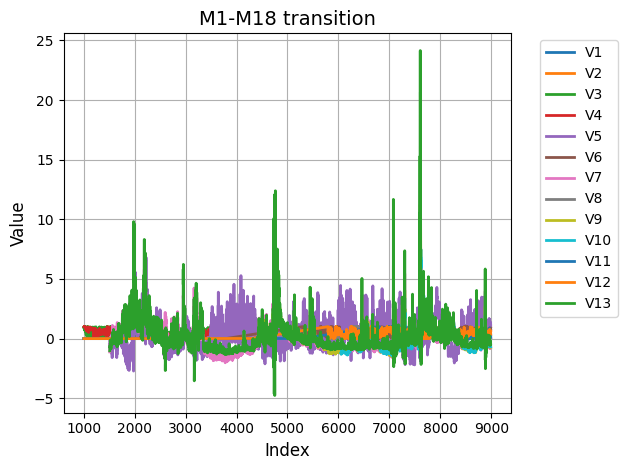

In [33]:
plt.figure(figsize=(30, 8))  # グラフサイズを大きめに設定

# M1からM18までの列を選択して描画
columns = [f'V{i}' for i in range(1, 14)]
df[columns].plot(linewidth=2)

plt.title('M1-M18 transition', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 凡例を右側に配置
plt.tight_layout()  # レイアウトの自動調整
plt.show()

<Figure size 3000x800 with 0 Axes>

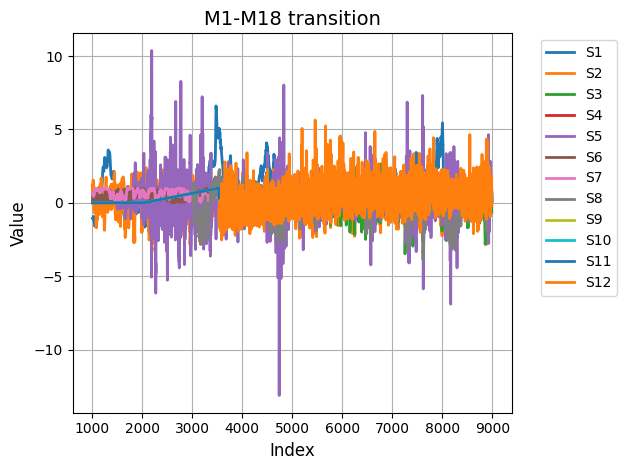

In [34]:
plt.figure(figsize=(30, 8))  # グラフサイズを大きめに設定

# M1からM18までの列を選択して描画
columns = [f'S{i}' for i in range(1, 13)]
df[columns].plot(linewidth=2)

plt.title('M1-M18 transition', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 凡例を右側に配置
plt.tight_layout()  # レイアウトの自動調整
plt.show()

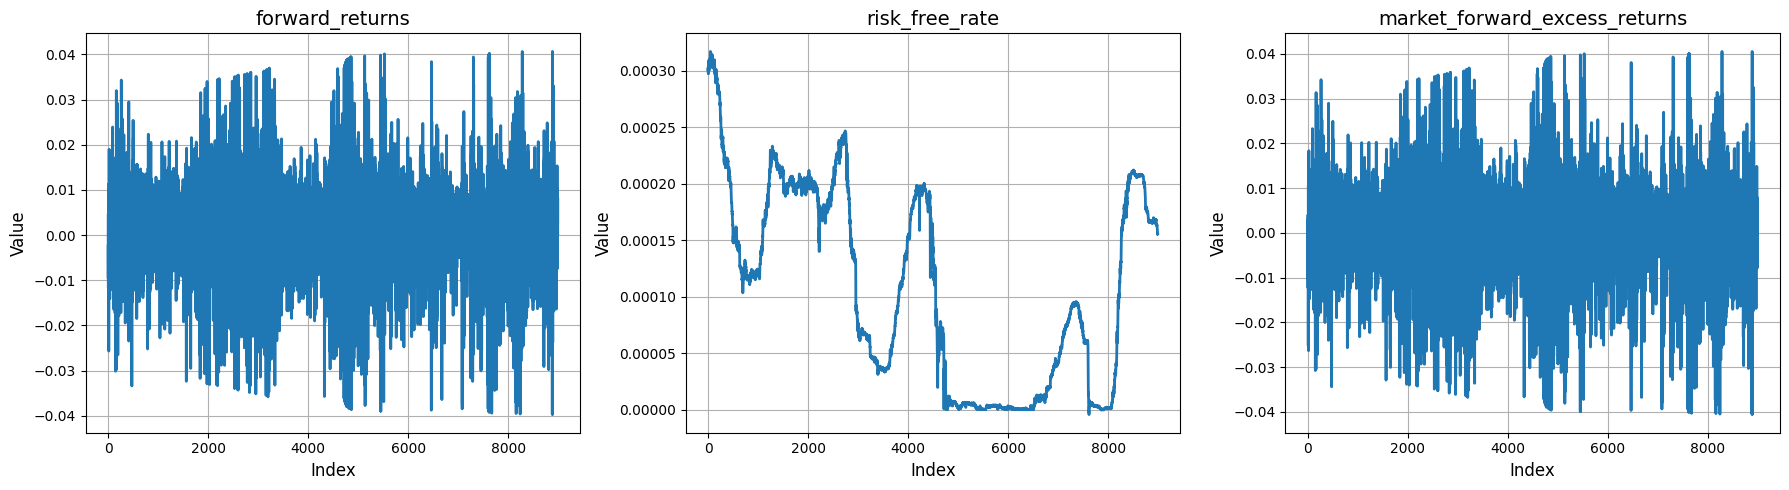

In [38]:
import matplotlib.pyplot as plt

# 描画するカラムを定義
columns = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# 横に3つ並べる
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(columns):
    axes[i].plot(df[col], linewidth=2)
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel('Index', fontsize=12)
    axes[i].set_ylabel('Value', fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


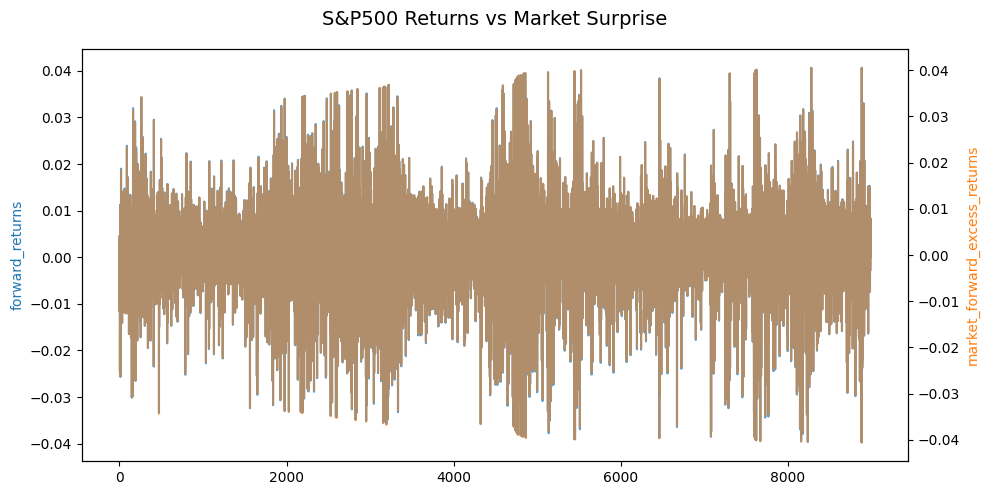

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(df['forward_returns'], color='tab:blue', label='forward_returns', alpha=0.7)
ax1.set_ylabel('forward_returns', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df['market_forward_excess_returns'], color='tab:orange', label='market_forward_excess_returns', alpha=0.5)
ax2.set_ylabel('market_forward_excess_returns', color='tab:orange')

fig.suptitle('S&P500 Returns vs Market Surprise', fontsize=14)
fig.tight_layout()
plt.show()


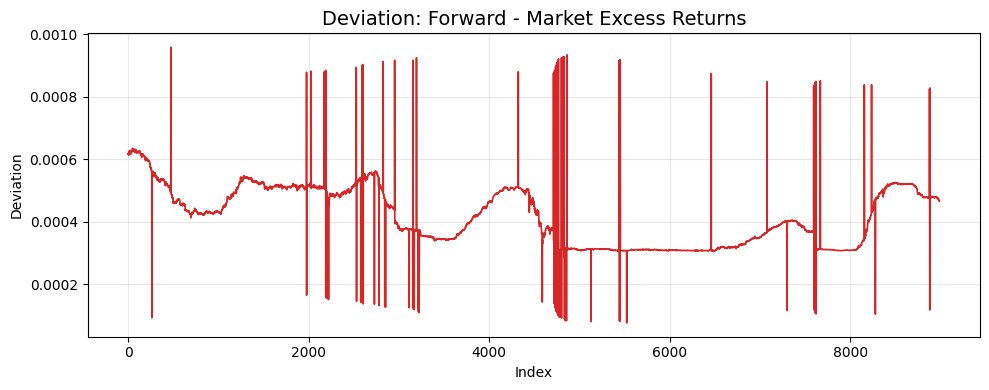

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(df['forward_returns'] - df['market_forward_excess_returns'],
         color='tab:red', linewidth=1.2)
plt.title('Deviation: Forward - Market Excess Returns', fontsize=14)
plt.xlabel('Index')
plt.ylabel('Deviation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## データ確認結果

- 特徴量（M*, E*, I*, P*, V*, S* …）の詳細は非公開のため、意味から特徴量エンジニアリングは不可っぽい。
- 予測対象：`market_forward_excess_returns`

### 意味
- `forward_returns`：S&P500 の翌日リターン（生の値）
- `market_forward_excess_returns`：
  - `forward_returns` から過去5年平均リターンを引いた値
  - 長期トレンド（例：+4%/年）を除いた「市場の上振れ・下振れ」率

### 要約
> 市場が平均的な動きより **どれだけ強気／弱気に振れたか（サプライズ）** を予測するコンペ。


<Figure size 2000x800 with 0 Axes>

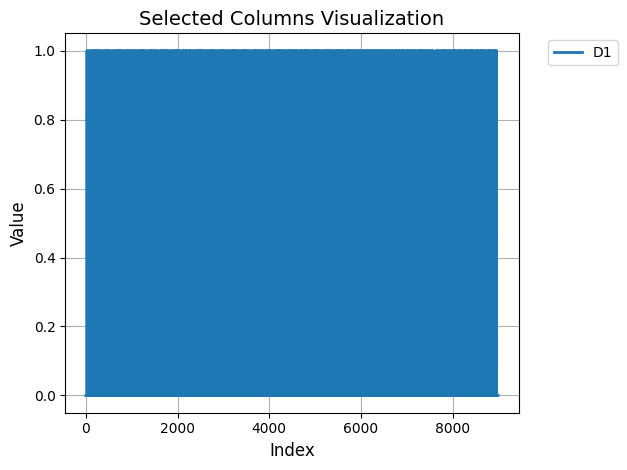

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_visualization_widgets():
    # 列の種類を選択するドロップダウン
    column_types = ['M', 'E', 'I', 'P', 'V', 'S', 'MOM', 'D']
    type_selector = widgets.Dropdown(
        options=['All'] + column_types,
        value='All',
        description='列の種類:',
        style={'description_width': 'initial'}
    )
    
    # 列を選択する複数選択ボックス
    columns = [col for col in df.columns if col.startswith(tuple(column_types))]
    column_selector = widgets.SelectMultiple(
        options=columns,
        value=[columns[0]],
        description='列を選択:',
        disabled=False,
        layout=widgets.Layout(width='50%', height='200px')
    )
    
    # 幅と高さの個別のスライダー
    width_slider = widgets.FloatSlider(
        value=15,
        min=5,
        max=20,
        step=0.5,
        description='幅:',
        style={'description_width': 'initial'}
    )
    
    height_slider = widgets.FloatSlider(
        value=8,
        min=5,
        max=20,
        step=0.5,
        description='高さ:',
        style={'description_width': 'initial'}
    )
    
    def update_columns(change):
        if change['new'] == 'All':
            new_columns = [col for col in df.columns if col.startswith(tuple(column_types))]
        else:
            new_columns = [col for col in df.columns if col.startswith(change['new'])]
        column_selector.options = new_columns
        column_selector.value = [new_columns[0]] if new_columns else []
    
    def plot_selected_columns(change=None):
        clear_output(wait=True)
        if len(column_selector.value) > 0:
            plt.figure(figsize=(width_slider.value, height_slider.value))
            df[list(column_selector.value)].plot(linewidth=2)
            plt.title('Selected Columns Visualization', fontsize=14)
            plt.xlabel('Index', fontsize=12)
            plt.ylabel('Value', fontsize=12)
            plt.grid(True)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
        
        # ウィジェットを再表示
        display(widgets.VBox([
            type_selector,
            column_selector,
            widgets.HBox([width_slider, height_slider])
        ]))
    
    # イベントハンドラーを設定
    type_selector.observe(update_columns, names='value')
    column_selector.observe(plot_selected_columns, names='value')
    width_slider.observe(plot_selected_columns, names='value')
    height_slider.observe(plot_selected_columns, names='value')
    
    # 初期表示
    plot_selected_columns()

# ウィジェットを作成して表示
create_visualization_widgets()